# Pre-process

## Load library and define some functions needed

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import datetime as dt
import random
import time

import json
import os.path
import gc

from script.module.FeatureProducer import FeatureProducer 
from script.module.LightFMProducer import LightFMProducer

MODEL_FILE_NAME = 'model.txt'

In [2]:
import numpy as np
import pandas as pd
import pickle
import implicit
import time
import os
import logging

from scipy.sparse import coo_matrix

LOG_FORMAT = '%(asctime)s %(levelname)s << %(message)s'
logging.basicConfig(level=logging.DEBUG, format=LOG_FORMAT, datefmt='%H:%M:%S')

In [3]:
def custom_cv(params, train_set, hold_out_set=None, k_fold=5, num_boost_round=20):
    x_train = train_set.data
    y_train = train_set.label
    n = x_train.shape[0]
    unit = n // k_fold

    cv_scores = []
    for k in range(k_fold):
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if k < k_fold - 1:
            continue
        ##### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_cv_valid = None
        y_cv_valid = None
        if k == k_fold - 1:
            x_cv_valid = x_train[unit * k:]
            y_cv_valid = y_train[unit * k:]
        else:
            x_cv_valid = x_train[unit * k: unit * (k + 1)]
            y_cv_valid = y_train[unit * k: unit * (k + 1)]

        x_cv_train = None
        y_cv_train = None
        if k == 0:
            x_cv_train = x_train[unit * (k + 1):]
            y_cv_train = y_train[unit * (k + 1):]
        elif k == k_fold - 1:
            x_cv_train = x_train[:unit * k]
            y_cv_train = y_train[:unit * k]
        else:
            x_cv_train = x_train[:unit * k].append(x_train[unit * (k + 1):])
            y_cv_train = y_train[:unit * k].append(y_train[unit * (k + 1):])

        cv_train_set = lgb.Dataset(x_cv_train, y_cv_train)
        cv_valid_set = lgb.Dataset(x_cv_valid, y_cv_valid)
        watchlist = [cv_valid_set]

        # not tested yet
        if hold_out_set is not None:
            watchlist.append(hold_out_set)
        model = lgb.train(params, train_set=cv_train_set, valid_sets=watchlist,
                          num_boost_round=num_boost_round, verbose_eval=5)
        print(model.best_score)
        cv_scores.append(model.best_score['valid_1']['auc'])

    tip_txt = '[CV]'
    tip_txt += ' ' + str(cv_scores)
    mean_cv_score = np.mean(cv_scores)
    tip_txt += '{ auc score=' + str(mean_cv_score) + ' }'
    print(tip_txt)

    return mean_cv_score

In [4]:
def custom_grid_search(params, own_grid_params, train_set, valid_set, num_boost_round=20):
    keys = []
    values = [list()]
    for key, value in own_grid_params.items():
        keys.append(key)
        new_values = []
        for item in values:
            for val in value:
                new_values.append(item + [val])
        values = new_values

    watchlist = [valid_set]
    grid_best_params = None
    grid_best_score = None

    for comb in values:
        own_params = {}
        for idx in range(len(keys)):
            own_params[keys[idx]] = comb[idx]
            params[keys[idx]] = comb[idx]

        cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=num_boost_round)

        tip_txt = '[GridSearch]'
        for idx in range(len(keys)):
            tip_txt += ' ' + str(keys[idx]) + '=' + str(comb[idx])
        tip_txt += ' { best_score: ' + str(cv_score) + ' }'
        print(tip_txt)

        if grid_best_score is None or cv_score > grid_best_score:
            grid_best_params, grid_best_score = own_params, cv_score

    tip_txt = '[GS Best Result]'
    for key, val in grid_best_params.items():
        tip_txt += ' ' + str(key) + '=' + str(val)
    tip_txt += ' { best_score: ' + str(grid_best_score) + ' }'
    print(tip_txt)
    
    return grid_best_params

## init

In [5]:
lp = LightFMProducer(root='./data') 

## load

In [6]:
lp.prepare()
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

(30755, 359966)


12:09:38 INFO << prepare in 88.67s


## preprocess

In [7]:
train_cf_df = lp.compute(True)
test_cf_df = lp.compute(False)

In [8]:
train_cf_df.drop(['msno', 'song_id', 'genre_ids', 'target'], axis=1, inplace=True)
test_cf_df.drop(['msno', 'song_id', 'genre_ids'], axis=1, inplace=True)

In [9]:
train_df = train_df.join(train_cf_df)
test_df = test_df.join(test_cf_df)

In [10]:
train_df

,msno,song_id,source_system_tab,source_screen_name,source_type,target,item_fac_0,item_fac_1,item_fac_2
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0.054610,-0.080498,-0.063403
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,0.046989,-0.081330,-0.060278
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,0.046989,-0.081330,-0.060278
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,0.100734,-0.155776,-0.097418
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,-0.216177,-0.070784,-0.262141
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,0.046989,-0.081330,-0.060278
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,0.052689,-0.081151,-0.062104
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,-0.216177,-0.070784,-0.262141
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,-0.655154,-0.521240,0.137335
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,0.052689,-0.081151,-0.062104


In [11]:
test_df

,id,msno,song_id,source_system_tab,source_screen_name,source_type,item_fac_0,item_fac_1,item_fac_2
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,-0.849156,0.632882,0.550786
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,0.052689,-0.081151,-0.062104
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist,-0.655154,-0.521240,0.137335
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,0.052689,-0.081151,-0.062104
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,-0.261495,0.011235,0.309943
5,5,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,NV3nhEcMqsawwvSNTUAt9IVAexHLOm0lDfrHyEfN5B0=,radio,Radio,radio,0.052689,-0.081151,-0.062104
6,6,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,DPM6G9RB5QO2dvAVPyc70gxHdvu872IjTUvV6LJT8ho=,radio,Radio,radio,0.052689,-0.081151,-0.062104
7,7,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,JGXB3PHc0CX0JskwwjmYP8i318BLo7DhChgEj6Yqjt8=,my library,Local playlist more,local-playlist,-0.849156,0.632882,0.550786
8,8,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,507plIkmke1jh3wMrHqKore82pPFozADwydR8P0Gx2Q=,radio,Radio,radio,0.052689,-0.081151,-0.062104
9,9,3ZQ6oGfcSiUoCrtBPKGa8hHCiFh5jqtDqPVDUl/zrjU=,HsgJXv1C7iVZiP7CWwWTfsmMhia6Huc0MUccfj+D02o=,my library,Local playlist more,local-library,0.052689,-0.081151,-0.062104


In [12]:
for column in train_df.columns:
    if train_df[column].dtype == object:
        train_df[column] = train_df[column].astype('category')

for column in test_df.columns:
    if test_df[column].dtype == object:
        test_df[column] = test_df[column].astype('category')

In [13]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 9 columns):
msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                int64
item_fac_0            float32
item_fac_1            float32
item_fac_2            float32
dtypes: category(5), float32(3), int64(1)
memory usage: 218.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 9 columns):
id                    int64
msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
item_fac_0            float32
item_fac_1            float32
item_fac_2            float32
dtypes: category(5), float32(3), int64(1)
memory usage: 83.2 MB
None


# LGBM training

## Correlation over all features (underconstruction...)

For categorical feature, need to numerize them.
Also, for all numeric features, it's necessary to be normalized.

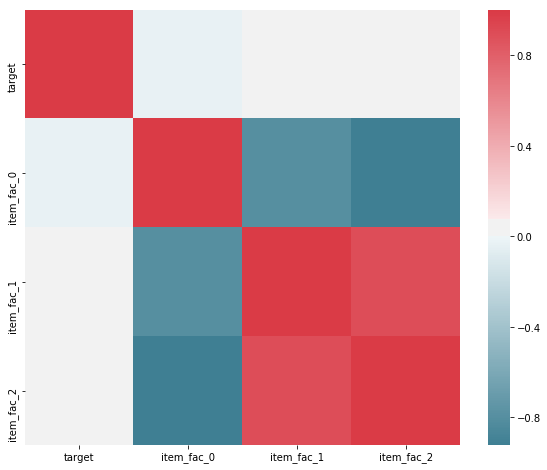

In [14]:
corr = train_df.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Prepare

In [15]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

# take the last # rows of train_df as valid set where # means number of rows in test_df
x_valid = train_df.drop(['target'], axis=1).tail(test_df.shape[0])
y_valid = train_df['target'].tail(test_df.shape[0])

x_test = test_df.drop(['id'], axis=1)
test_ids = test_df['id']

train_df.head(15)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,item_fac_0,item_fac_1,item_fac_2
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,0.054610,-0.080498,-0.063403
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,0.046989,-0.081330,-0.060278
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,0.046989,-0.081330,-0.060278
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,0.100734,-0.155776,-0.097418
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,-0.216177,-0.070784,-0.262141
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,0.046989,-0.081330,-0.060278
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,0.052689,-0.081151,-0.062104
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,-0.216177,-0.070784,-0.262141
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,-0.655154,-0.521240,0.137335
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,0.052689,-0.081151,-0.062104


## Core

In [16]:
train_set = lgb.Dataset(x, y)
valid_set = lgb.Dataset(x_valid, y_valid, free_raw_data=False)
watchlist = [valid_set]

params = dict({
    'learning_rate': 0.2,
    'application': 'binary',
    'min_data_in_leaf': 10,
#    'max_depth': 10,
    'num_leaves': 2 ** 7,
    'max_bin': 255,
    'verbosity': 0,
    'metric': 'auc'
})

grid_params = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [8, 10],
}

# best_grid_params = custom_grid_search(params, grid_params, train_set, hold_out_set, num_boost_round=20)
# for key, val in best_grid_params.items():
#     params[key] = best_grid_params[key]

cv_score = custom_cv(params, train_set, valid_set, k_fold=4, num_boost_round=200)
print(cv_score)

model = lgb.train(params, train_set=train_set, valid_sets=watchlist, num_boost_round=200, verbose_eval=5)
y_test = model.predict(x_test)

# When CV, valid_0 means the front 75% training, the last 25% validating
#          valid_1 means the front 75% training, the last "len(test set)" validating
#
# When LGBM running, valid_0 means 100% training, the last "len(test set)" validating.
#
# Use CV valid_0 auc score to predict result!

[5]	valid_0's auc: 0.644806	valid_1's auc: 0.663973


KeyboardInterrupt: 

## Feature importances

In [ ]:
plot_df = pd.DataFrame({'features': train_df.columns[train_df.columns != 'target'],
                        'importances': model.feature_importance()})
plot_df = plot_df.sort_values('importances', ascending=False)

plt.figure(figsize=(8, 15))
sns.barplot(x = plot_df.importances, y = plot_df.features)
plt.show()

## Output

In [ ]:
submission_df = pd.DataFrame()
submission_df['id'] = test_ids
submission_df['target'] = y_test
# string file compression reduces file size
submission_df.to_csv('script/submit/submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
submission_df.info()